Getting familiar with DR. Mussman's research assignment

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import sklearn
import re

In [195]:
df = pd.read_csv("data/ACSST1Y2010.S0101.csv")
df["label"] = df["Label (Grouping)"].str.strip()
df.to_csv("age_estimates_only.csv", index=False)
# print(df.head)

dude = df.to_numpy()
print(dude)

[['Total population' '4,785,298' '*****' ... '1,936,867' '±2,651'
  'Total population']
 ['AGE' nan nan ... nan nan 'AGE']
 ['\xa0\xa0\xa0\xa0Under 5 years' '6.4%' '±0.1' ... '5.5%' '±0.1'
  'Under 5 years']
 ...
 ['PERCENT IMPUTED' nan nan ... nan nan 'PERCENT IMPUTED']
 ['\xa0\xa0\xa0\xa0Sex' '0.1%' '(X)' ... '(X)' '(X)' 'Sex']
 ['\xa0\xa0\xa0\xa0Age' '1.1%' '(X)' ... '(X)' '(X)' 'Age']]


In [197]:
import pandas as pd
import numpy as np
import re

def build_state_age_matrix(csv_path):
    df = pd.read_csv(csv_path)
    df["label"] = df["Label (Grouping)"].str.strip()
    # --- 1. keep the 18 "simple" age rows -----------------------------
    age_rows = df[df["Label (Grouping)"].str.match(r"^\s{4}(Under|\d)")].iloc[:18]
    age_labels = age_rows["Label (Grouping)"].str.strip().tolist()

    tot_cols = df.filter(regex=r"!!Total!!Estimate$").columns
    states = [c.split("!!")[0] for c in tot_cols]  # strip "!!Total!!Estimate"

    # --- 3. convert to floats and reshape -----------------------------
    age_pct_df = (
        age_rows[tot_cols]
        .apply(lambda s: s.str.rstrip("%").astype(float))  # strip % → float
        .T                                                 # states become rows
        .reset_index(drop=True)
    )
    age_mat = age_pct_df.to_numpy(dtype=float)  # (52, 18)
    age_mat *= .01
    return age_mat, states, age_labels

def multiply_percentages_and_totals(age_matrix, csv_path):
    df = pd.read_csv(csv_path)
    # total-population counts for each state (row 0 of each *!!Total!!Estimate column)
    totals = (
        df.filter(regex=r"!!Total!!Estimate$").iloc[0]
        .str.replace(",", "").astype(int)
        .to_numpy()                                           # shape (52,)
    )
    # broadcast: (52, 1) * (52, 18) → (52, 18)
    counts = totals[:, None] * age_matrix
    return counts, totals
# print(state_names[:5])    # ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California']
# print(age_groups)         # ['Under 5 years', '5 to 9 years', ... '85 years and over']

# age_matrix, state_names, age_groups = build_state_age_matrix("data/ACSST1Y2010.S0101.csv")
# multiplied, totals = multiply_percentages_and_totals(age_matrix, "data/ACSST1Y2010.S0101.csv")
# print(multiplied.shape) # 52 x 18, what I want is 9 x 52 x 18

## years 2010-2016 all have a percentage for individual totals, after that they just store the actual totals

def age_totals_no_percentage(csv_path):
    df = pd.read_csv(csv_path)
    age_rows = df[df["Label (Grouping)"].str.match(r"^\s{4}(Under|\d)")].iloc[:18]
    age_labels = age_rows["Label (Grouping)"].str.strip().tolist()
    tot_cols = df.filter(regex=r"!!Total!!Estimate$").columns
    states = [c.split("!!")[0] for c in tot_cols]  # strip "!!Total!!Estimate"
    # print(states)
    # print(len(states))
    age_matrix = df[tot_cols]
    age_matrix = age_matrix.iloc[2:20:] ##
    age_matrix = age_matrix.to_numpy() # (18 x 52). Rows are the age-group-defined totals, and columns are the states in alphabetical order
    for r in range(len(age_matrix)):
        for c in range(len(age_matrix[r])):
            age_matrix[r][c] = int(age_matrix[r][c].replace(",", ""))
    return age_matrix.T # (52x18) np array that represents the int populations for the 52 states

def populate_training_array(): # (2, 13, 1, 52)
    train_array = np.zeros((10, 52, 18))
    test_array = np.zeros((3, 52, 18)) #2021-2023
    # returned = np.array((6, ))
    i = 10
    train_index = 0
    test_index = 0
    file_path_prefix = "data/ACSST1Y20"
    while (i <= 16):
        path_string = file_path_prefix + str(i) + ".S0101.csv"
        age_matrix, state_names, age_groups = build_state_age_matrix(path_string)
        multiplied, totals = multiply_percentages_and_totals(age_matrix, path_string)
        # print(train_index)
        # print(f"year = {i} | train index = {train_index}")
        train_array[train_index] = multiplied
        train_index += 1
        i += 1
    while (i <= 20):
        if (i == 20):
            i += 1
            break
        path_string = file_path_prefix + str(i) + ".S0101.csv"
        age_matrix = age_totals_no_percentage(path_string)
        # print(train_index)
        # print(f"year = {i} | train index = {train_index}")
        # print(f"train index = {train_index}")
        train_array[train_index] = age_matrix
        train_index += 1
        i += 1
    print("------------------------------------------------")
    while i <= 23:
        path_string = file_path_prefix + str(i) + ".S0101.csv"
        age_matrix = age_totals_no_percentage(path_string)
        # print(test_index)
        # print(f"year = {i} | test index = {test_index}")
        test_array[test_index] = age_matrix
        test_index += 1
        i += 1
    print(f"Training array shape = {train_array.shape}")
    print(f"Test array shape = {test_array.shape}")

    return train_array, test_array


# age_totals_no_percentage("data/ACSST1Y2017.S0101.csv")

Now that I've fucked around enough, I can make methods to repeatedly pass shit in and filter it out.

In [198]:
train_array, test_array = populate_training_array()
# train array = (10, 52, 18). meaning (years 10-19, 52 states, 18 age ranges)
# tets array = (3, 52, 18). meaning (years 21-23, 52 states, 18 age ranges)
x = train_array[:8]
y = train_array[1:9]
x =  x.reshape((8 * 52), 18)
y = y.reshape((8 * 52), 18)
print(x.shape)
print(y.shape)
test_x = test_array[:2]
test_y = test_array[1:3]
print(test_x.shape)
test_x = test_x.reshape((2*52), 18)
y_actual = test_array[1:3]
y_actual = y_actual.reshape((2 * 52), 18)

def rel_error_for_alpha(a):
    model = sklearn.linear_model.Ridge(alpha=a, fit_intercept=True)
    model.fit(x, y)
    y_pred   = model.predict(test_x)          # (104, 18)
    y_actual = test_y.reshape(104, 18)        # the same shape
    rel_error = np.mean(np.abs(y_pred - y_actual) / y_actual)
    return rel_error


------------------------------------------------
Training array shape = (10, 52, 18)
Test array shape = (3, 52, 18)
(416, 18)
(416, 18)
(2, 52, 18)


Now that I am able to populate the training and testing arrays for the values, I need to test the relative error for the different values of alpha.


------------------------------------------------
Training array shape = (10, 52, 18)
Test array shape = (3, 52, 18)
After running the sweep, I know the best alpha is :100000000.0 with rel_e= 0.03346860331278655


Text(0.5, 1.0, 'Ridge coefficients (α = 1e+08)')

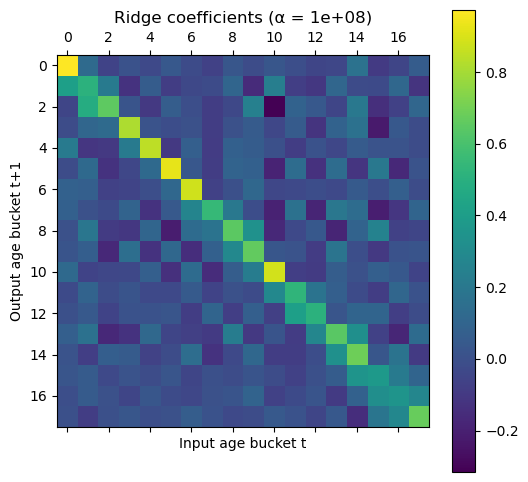

In [199]:
populate_training_array()  

alphas_rel_error = {}
min_rel_e = 10000
a = 0.001
while (a < 100000000000):
    relative_error = rel_error_for_alpha(a)
    # alphas_rel_error.append((a, relative_error))
    alphas_rel_error[a] = relative_error
    if (relative_error < min_rel_e):
        min_rel_e = relative_error
        best_alpha = a
        
    a *= 10
print(f"After running the sweep, I know the best alpha is :{best_alpha} with rel_e= {alphas_rel_error[best_alpha]}")



# # ---- nicer plot --------------------------------------------------------
# alphas = np.array(sorted(alphas_rel_error))               # shape (K,)
# errors = np.array([alphas_rel_error[a] for a in alphas])  # shape (K,)

# fig, ax = plt.subplots(figsize=(6,4))
# ax.semilogx(alphas, errors, marker='o', linewidth=2)      # log-x
# ax.set_xlabel(r"Ridge penalty  $\alpha$ (log scale)")
# ax.set_ylabel("Mean relative error")
# ax.set_title("α sweep for Ridge model")

# # highlight the minimum
# idx_best = np.argmin(errors)
# ax.plot(alphas[idx_best], errors[idx_best], 'ro')         # red dot
# ax.annotate(f"best\nα={alphas[idx_best]:.3g}\nMRE={errors[idx_best]:.4f}",
#             xy=(alphas[idx_best], errors[idx_best]),
#             xytext=(0, 10), textcoords="offset points",
#             ha='center', color='red')

# ax.grid(True, which="both", ls='--', alpha=0.6)
# plt.tight_layout()
# plt.show()

import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.matshow(model.coef_, fignum=0)
plt.colorbar()
plt.xlabel('Input age bucket t')
plt.ylabel('Output age bucket t+1')
plt.title('Ridge coefficients (α = %g)' % best_alpha)


# Display the plot
# plt.show()